# Task 1 - Exploratory Data Analysis (EDA)
- This notebook aims to present the findings of my analysis, and also a detailed walkthrough of the steps taken to derive the results.

# Data Preparation
**Purpose:**
- Prepare or process the raw data to make it suitable for further analysis or modelling, by handling missing values, encoding categorical variables, and perform other necessary transformations

## Preparing database ('.db') files

#### Use `sqlite3` library to prepare database ('.db') files

In [52]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Define a 'get database connection' function for reusability and readability

In [53]:
# Define a function that returns database connection object

def get_db_connection(url):
    conn = sqlite3.connect(url)        # points database connection object to conn
    conn.row_factory = sqlite3.Row     # set return rows as dictionaries instead of tuples
    return conn

#### Load **cruise_pre.db** and **cruise_post.db** into Python environment
- Dataset are read into a list of dictionaries, with each dictionary representing an individual row of data

- This is an intermediary step before converting to DataFrame

In [54]:
# Read cruise_pre.db and cruise_post.db into list of dictionaries

# Define required variables to store data from db
cruise_pre_data = []
cruise_post_data = []

# Define variable to store name of the tables
table_name = ['cruise_pre','cruise_post']

# Iterate through the 2 provided data sets: cruise_pre.db and cruise_post.db
for table in table_name:

    # Create connection to database using defined function
    conn = get_db_connection('data/'+ table + '.db')
    # Execute query to fetch all rows and columns
    data = conn.execute('SELECT * FROM {}'.format(table)).fetchall()

    # Append row to respective variable store
    if table == 'cruise_pre':
        for row in data:
            cruise_pre_data.append(dict(row))
    else:
        for row in data:
            cruise_post_data.append(dict(row))

# close database connection after completion of task
conn.close()

# Output: cruise_pre_data and cruise_post_data now contains list of dictionaries

#### Convert list of dict to Pandas DataFrame
**Purpose:**
- Convert to Pandas DataFrame objects as it unlocks a wide variety of simple and clean data analytics libraries

In [55]:
# Read list of dictionaries into Pandas Dataframe
# Set 'index' column as index
cruise_post_df = pd.DataFrame(data=cruise_post_data).set_index('index')
cruise_pre_df = pd.DataFrame(data=cruise_pre_data).set_index('index')

# Basic Data Exploration
**Purpose:**
- Get basic understanding of the structure, content and quality of the datasets
- Identify any missing data that may impact analysis

## Basic Information about the dataset using describe() and info()

In [56]:
cruise_pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133746 entries, 0 to 133745
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      120290 non-null  object 
 1   Date of Birth                               119062 non-null  object 
 2   Source of Traffic                           133746 non-null  object 
 3   Onboard Wifi Service                        114254 non-null  object 
 4   Embarkation/Disembarkation time convenient  118103 non-null  float64
 5   Ease of Online booking                      115391 non-null  float64
 6   Gate location                               116606 non-null  float64
 7   Logging                                     133746 non-null  object 
 8   Onboard Dining Service                      116937 non-null  object 
 9   Online Check-in                             118059 non-null  float64
 

In [57]:
cruise_pre_df.describe()

,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness
count,118103.000000,115391.000000,116606.000000,118059.000000,113494.000000,119914.000000,113453.000000,119399.000000,115419.000000,115344.000000
mean,3.055850,2.758170,2.978526,3.249884,3.439574,3.383925,3.633416,3.308470,3.641844,3.285745
std,1.526012,1.401888,1.277984,1.350811,1.321604,1.287508,1.178899,1.266476,1.177988,1.313328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [58]:
print(cruise_post_df.info())
print(cruise_post_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133746 entries, 0 to 133745
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Cruise Name      117815 non-null  object 
 1   Ticket Type      113685 non-null  object 
 2   Cruise Distance  119260 non-null  object 
 3   Ext_Intcode      133746 non-null  object 
 4   WiFi             64012 non-null   float64
 5   Dining           133746 non-null  int64  
 6   Entertainment    73689 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 8.2+ MB
None
               WiFi         Dining  Entertainment
count  64012.000000  133746.000000   73689.000000
mean       0.500578       0.499290       0.503142
std        0.500004       0.500001       0.499994
min        0.000000       0.000000       0.000000
25%        0.000000       0.000000       0.000000
50%        1.000000       0.000000       1.000000
75%        1.000000       1.000000       1.000000


## Understand the spread of missing values

In [59]:
# Print how many missing values in each data set

print('Pre-trip survey data')
print('Column Name --------------------------- Missing Values')
print(cruise_pre_df.isnull().sum())
print('\nPost-cruise data')
print('Column Name -- Missing Values')
print(cruise_post_df.isnull().sum())

Pre-trip survey data
Column Name --------------------------- Missing Values
Gender                                        13456
Date of Birth                                 14684
Source of Traffic                                 0
Onboard Wifi Service                          19492
Embarkation/Disembarkation time convenient    15643
Ease of Online booking                        18355
Gate location                                 17140
Logging                                           0
Onboard Dining Service                        16809
Online Check-in                               15687
Cabin Comfort                                 20252
Onboard Entertainment                         15913
Cabin service                                 13832
Baggage handling                              20293
Port Check-in Service                         14347
Onboard Service                               18327
Cleanliness                                   18402
Ext_Intcode                             

Text(0.5, 1.0, 'cruise_post_df')

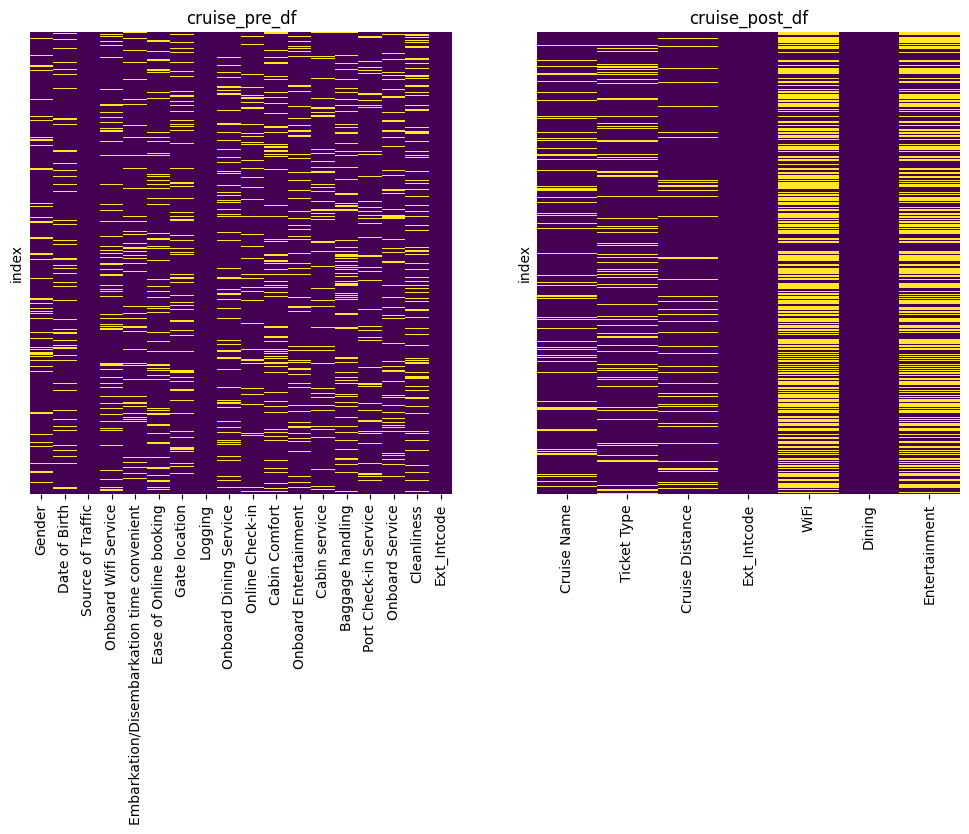

In [60]:
# Visualise the null values in each data set

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap (cruise_pre_df)
sns.heatmap(cruise_pre_df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('cruise_pre_df')

# Plot the second heatmap (cruise_post_df)
sns.heatmap(cruise_post_df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title('cruise_post_df')


## Understand the values in the columns

Executing the next line, we can see the different values in `Onboard Wifi Service`, `Onboard Entertainment` and `Onboard Dining Service` columns:
1. 'A little important'
2. 'Extremely important'
3. 'Not at all important'
4. 'Somewhat important'
5. 'Very important'

And these are the values for `Ticket Tier`
1. 'Deluxe'
2. 'Luxury'
3. 'Standard'

In [61]:
# Summarise the values for some columns in pre-trip data
scale_summary = pd.concat([cruise_pre_df.groupby('Onboard Wifi Service').size(),
                        cruise_pre_df.groupby('Onboard Entertainment').size(),
                        cruise_pre_df.groupby('Onboard Dining Service').size()],
                        axis=1,
                        keys=['Wifi Service Count', 'Entertainment Count', 'Dining Service Count'])
scale_summary

,Wifi Service Count,Entertainment Count,Dining Service Count
A little important,29383,20009,24763
Extremely important,13031,28625,25149
Not at all important,20236,14205,14468
Somewhat important,29101,21627,25037
Very important,22503,33367,27520


In [62]:
# Summarise values in Ticket Type in post-trip data
cruise_post_df.groupby('Ticket Type').size()

Ticket Type
Deluxe       8260
Luxury      54414
Standard    51011
dtype: int64

## Findings
These findings are made based on the investigations in the previous segments.

### Pre-purchase survey
Description
- This is a pre-purchase survey conducted to give ShipSail insights into what ameneties/services their customers prefer, or what is considered important to them for an enjoyable cruise journey.

**Missing values, or NaN fields**
- Spread of missing data is very even across all feature columns
- Missing data from each column is generally small, roughly 20% to 30% (visually)
- Imputation will be used to replace missing values

**Inconsistent label format**
- For example, `Onboard Wifi Service` has a categorical label while `Ease of Online booking` has a numerical label, both being a preferance rating
- Inconsistent format makes data plotting across these variables difficult
- Based on the unique values, the categorically labelled fields are in order, can be easily mapped to their corresponding numerical value, as per the scale given in AIAP15 instructions
- Encode all categorical labels into corresponding numerical label of 1.0 to 5.0




In [63]:
# Display part of cruise pre dataset
cruise_pre_df.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


### Post-cruise Customer Data
Description:
- This is the post trip data, which contains the target variable 'Ticket Type' we are trying to predict.

**Missing values, or NaN fields in Ticket Type**
- About 15% missing values
- Imputation is not recommended for the target variable, as it can introduce bias, incorrect or misleading information.
- These rows will be dropped for this project.

**Unique values in Ticket Type**
- Deluxe (8260), Luxury (54414), Standard (51011)

In [64]:
# Display part of cruise post dataset
cruise_post_df.head()

,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
index,,,,,,,
0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


# Data Cleaning

## Merging both datasets
**Purpose:** 
- combining pre-cruise survey data and post-cruise data creates a more comprehensive and unifed dataset, allowing analysis of the relationship between both sets
- it also creates a direct link between the pre-cruise survey responses (features) and the ticket tier column (target variable) from post-cruise data

In [65]:
# Create a new variable that holds the merged set of Dataset 1 and 2

merged_data = cruise_pre_df.merge(cruise_post_df, left_on='Ext_Intcode', right_on='Ext_Intcode')

# Display part of the new merged dataset
merged_data.head(3)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,...,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,...,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0


## Standardising values for survey questions

**Purpose:**
1. inconsistent format makes data plotting across these variables difficult
2. machine learning algorithms require numeric input variables

3 Scale Columns are categorically labelled: 
1. `Onboard Wifi Service`
2. `Onboard Entertainment`
3. `Onboard Dining Service`

**Conclusion:**
- All feature columns will be consistent


In [66]:
# Based on the findings, there are no misspelling or outliers to be handled

# Define a string-to-value map to help encode these columns
scale_map = {'Not at all important':1.0,
                'A little important':2.0,
                'Somewhat important':3.0,
                'Very important': 4.0,
                'Extremely important':5.0}

# Store columns to encode
encode_columns = ['Onboard Wifi Service', 'Onboard Entertainment', 'Onboard Dining Service']

# Iterate encoding for each column
for column in encode_columns:
    merged_data[column] = merged_data[column].map(scale_map)

In [67]:
# Show part of the resulting dataframe
merged_data.head(3)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,2.0,3.0,5.0,3.0,01/01/2023 0:00,4.0,2.0,...,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,1.0,4.0,1.0,NaN,01/01/2023 0:01,4.0,NaN,...,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,NaN,3.0,0.0,5.0,01/01/2023 0:02,NaN,NaN,...,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0


## Standardising `Cruise Name`

Running the line of code below, these are the values found:
1. "Blastoise"
2. "IAPRAS"
3. "Lapras"
4. "blast"
5. "blast0ise"
6. "blastoise"
7. "blastoise"
8. "lap"
9. "lapras"

There are only 2 cruises, and the correct spellings are:
1. "Blastoise"
2. "Lapras"

In [68]:
# Find unique values in Cruise Name
merged_data.groupby('Cruise Name').size()

Cruise Name
Blastoise    73209
IAPRAS        3043
Lapras       32823
blast         3226
blast0ise     3070
blastoise     3073
lap           3068
lapras        3125
dtype: int64

In [69]:
# Define function to replace misspellings with correct spelling
def correct_spelling(cruise_name):
    # Define a list to store misspellings
    blastoise_misspell = ['blast', 'blast0ise', 'blastoise']
    lapras_misspell = ['IAPRAS', 'lap', 'lapras']

    if cruise_name in blastoise_misspell:
        return 'Blastoise'
    elif cruise_name in lapras_misspell:
        return 'Lapras'
    else:
        return cruise_name  # Return the original name if not a misspelling

# Apply function to 'Cruise Name' column
merged_data['Cruise Name'] = merged_data['Cruise Name'].apply(correct_spelling)

## Features Engineering

### Create `Age` column from `Date of Birth` and `Logging`
**Purpose:** 
- Create a more usable variable that can give more insights into the demographics

In [70]:
def convert_to_dmy(date_of_birth):
    if date_of_birth is not None:
        try:
            # Try to parse the date assuming %d/%m/%Y format
            date_obj = pd.to_datetime(date_of_birth, format='%d/%m/%Y')
            return date_obj.strftime('%d/%m/%Y')
        except ValueError:
            try:
                # If parsing fails, try parsing with %Y/%d/%m format
                date_obj = pd.to_datetime(date_of_birth, format='%Y/%d/%m')
                return date_obj.strftime('%d/%m/%Y')
            except ValueError:
                try:
                    # If parsing fails, try parsing with %Y/%m/%d format
                    date_obj = pd.to_datetime(date_of_birth, format='%Y/%m/%d')
                    return date_obj.strftime('%d/%m/%Y')
                except ValueError:
                    # If all formats fail, return the original value
                    return date_of_birth
    else:
        return date_of_birth


# Apply function to every row in cruise_pre_df
merged_data['Date of Birth'] = merged_data['Date of Birth'].apply(convert_to_dmy)

# Add a new column 'Age', compute age by subtracting logging date by their date of birth, getting the quotient after dividing by 365
merged_data['Age'] = (pd.to_datetime(merged_data['Logging'], format='%d/%m/%Y %H:%M') - pd.to_datetime(merged_data['Date of Birth'], format='%d/%m/%Y')).dt.days // 365


Running the next line, there guests who are aged over 120, which is most likely an error.

Solution:
- Drop rows with age > 120

In [71]:
# Summarise counts of age more than 80
merged_data[merged_data['Age']>80].groupby('Age').size()

Age
84.0     17
85.0     11
123.0    31
124.0    45
125.0    55
         ..
219.0    60
220.0    52
221.0    46
222.0    48
223.0    18
Length: 103, dtype: int64

In [72]:

merged_data = merged_data[merged_data['Age'] <= 120]

## Handling Missing Values

### Drop NaN rows in `Ticket Type` column
Since this is our target variable, imputing missing values can make the result misleading

##### Analyze sensitivity of replacing missing values with mean, mode or median value
**Purpose:** 
- To visualize the impact of imputation versus dropping data

**Conclusion:**
- Dropping all NaN rows means more than 95% rows will be dropped, which is not ideal.

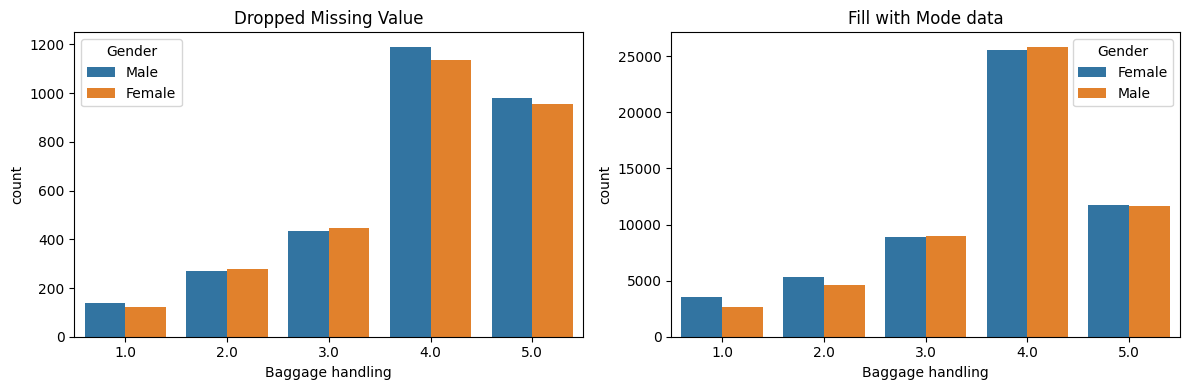

In [73]:
import warnings
warnings.filterwarnings("ignore")

x_column = 'Baggage handling' # Change value here to view different column

# Create a temporary dataframe copy to drop missing value
dropped_data = merged_data.copy()
dropped_data.dropna(inplace=True)

# Create a temporary dataframe copy to perform missing data fill
adjusted_data = merged_data.copy()
adjusted_data[x_column].fillna(merged_data[x_column].mode()[0], inplace=True)

# Create a 1 by 2 sub-plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Ease of Online booking count plot without filling NaN values
plot1 = sns.countplot(data=dropped_data,
                    x=x_column,
                    hue='Gender',
                    ax=axes[0])
plot1.set_title('Dropped Missing Value')


# Ease of Online booking count plot after filling with mode data
plot2 = sns.countplot(data=adjusted_data,
                    x=x_column,
                    hue='Gender',
                    ax=axes[1])
plot2.set_title('Fill with Mode data')

plt.tight_layout()
plt.show()

**Scale/Rating Feature Columns**
- For scale columns (where guests indicate their level of preference), we can replace NaN values with that column's most occuring importance, aka the `mode`.
- This approach leverages on available data to estimate the missing scales.
- Allows more data points to be kept, while also not skewing the data if extreme default values are used (e.g 0)
- `Mean` can be used too but since scales are whole numbers, `mode` is slightly more suited.

**Gender Feature Column**
- Employ the same approach, replacing NaN fields with `mode` of `Gender` column

**Date of Birth Feature Column**
- Calculate the age of guest, and fill missing age values with the `mean` age

In [74]:
# Define a list of column names that belongs to guest's scale rating
scale_columns = ['Onboard Wifi Service',
                 'Embarkation/Disembarkation time convenient',
                 'Ease of Online booking',
                 'Gate location',
                 'Onboard Dining Service',
                 'Online Check-in',
                 'Cabin Comfort',
                 'Onboard Entertainment',
                 'Cabin service',
                 'Baggage handling',
                 'Port Check-in Service',
                 'Onboard Service',
                 'Cleanliness']
# Iterate through each scale column, fill NaN fields with the mode of that column
# for column in scale_columns:
#     cruise_pre_df[column].fillna(cruise_pre_df[column].mode()[0], inplace=True)

# Similarly for Gender, fill NaN gender field with mode of the Gender column
# cruise_pre_df['Gender'].fillna(cruise_pre_df['Gender'].mode()[0], inplace=True)


**Resulting `cruise_pre_df` so far:**
- All scales are in proper numerical label, and missing values are filled via `mode` imputation
- Gender was assigned binary label (`Male` = 0, `Female` = 1), and missing values are filled via `mode` imputation
- Source of Traffic was ordinally labelled and missing values filled via `mode` imputation
    - `'Direct - Company Website':0.0`
    - `'Direct - Email Marketing':1.0`
    - `'Indirect - Search Engine':2.0`
    - `'Indirect - Social Media':3.0`

In [75]:
# Show part of resulting cruise_pre_df
cruise_pre_df.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


# Analysis

In [76]:
merged_data.groupby('Age').size()

Age
6.0     433
7.0     698
8.0     758
9.0     789
10.0    819
       ... 
78.0     48
79.0     77
80.0     44
84.0     17
85.0     11
Length: 77, dtype: int64

<Axes: xlabel='Ease of Online booking', ylabel='count'>

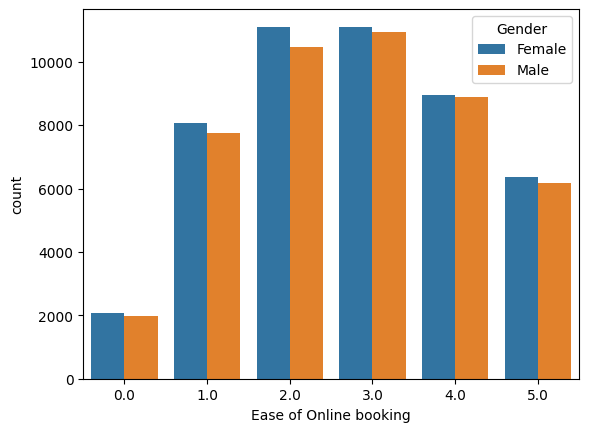

In [77]:
sns.countplot(data=merged_data, x = 'Ease of Online booking', hue='Gender')

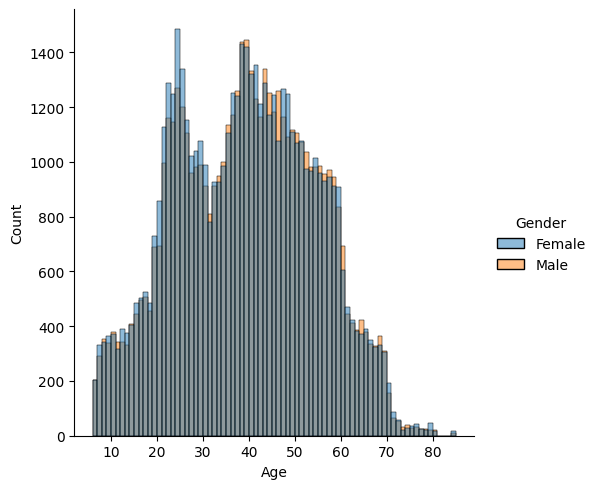

In [78]:
sns.displot(data=merged_data, kind='hist', x = 'Age', hue='Gender')

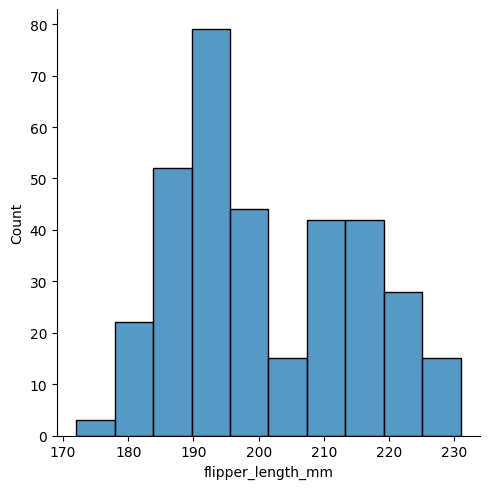

In [79]:
penguins = sns.load_dataset('penguins')
sns.displot(data=penguins, x='flipper_length_mm')
